In [1]:
import copy
import warnings

import numpy as np
import xarray as xr

import sys, pdb, traceback

import matplotlib.pyplot as plt

import rotunno as rt
import qian_helpers
import rotunno_helpers

import copy

import scipy as sp

In [2]:
import mpmath
erfi = np.frompyfunc(mpmath.erfi, 1, 1)

In [3]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport rotunno, rotunno_helpers, channel_helpers, qian_helpers, piecewise_N_helpers, continuous_N_helpers, convective_helpers

In [4]:
delT = 20
.5*9.807*delT/300/(12*3600)

7.56712962962963e-06

In [5]:
.5*9.807*delT/300/(24*3600)

3.783564814814815e-06

In [13]:
# YMC parameters
L_star = 50*1e3 # m
omega = 2*np.pi/(24*3600)
h = 1*1e3
h1_star = 2*1e3
H1 = h1_star/h
N1 = 0.01
L = omega*L_star/(N1*h)
Q0 = 1.2e-5
# Q0=7.57e-6
# Q0=3.8e-6
phi = -11.5
f = 2*omega*np.sin(-11.5*np.pi/180)
A = np.sqrt(1-f**2/omega**2)

In [56]:
# YMC convection parameters
L_star = 100*1e3 # m
omega = 2*np.pi/(24*3600)
h = 12*1e3
D_star = 4*1e3
h1_star = 17*1e3
H1 = h1_star/h
N1 = 0.01
N2 = 0.025
N = N2/N1
L = omega*L_star/(N1*h)
Q0 = 6e-6
# Q0=7.57e-6
# Q0=3.8e-6
phi = -11.5
f = 2*omega*np.sin(phi*np.pi/180)
A = np.sqrt(1-f**2/omega**2)

H1_star_tl = 15e3
H2_star_tl = 19e3
H1_star_pw = 17e3
H1_tl = H1_star_tl / h
H2_tl = H2_star_tl / h
H1_pw = H1_star_pw / h
D = D_star / h

In [12]:
# YMC test
L_star = 100*1e3 # m
omega = 2*np.pi/(24*3600)
h = 8*1e3
D_star = 6*1e3
h1_star = 17*1e3
H1 = h1_star/h
N1 = 0.01
N2 = 0.025
N = N2/N1
L = omega*L_star/(N1*h)
Q0 = 6e-6
# Q0=7.57e-6
# Q0=3.8e-6
phi = -11.5
f = 2*omega*np.sin(phi*np.pi/180)
A = np.sqrt(1-f**2/omega**2)

H1_star_tl = 15e3
H2_star_tl = 19e3
H1_star_pw = 17e3
H1_tl = H1_star_tl / h
H2_tl = H2_star_tl / h
H1_pw = H1_star_pw / h
D = D_star / h

In [4]:
# Inversion parameters
L_star = 50*1e3 # m
omega = 2*np.pi/(24*3600)
h = 1*1e3
h1_star = 2*1e3
H1 = h1_star/h
N1 = 0.01
L = omega*L_star/(N1*h)
Q0 = 1.2e-5
# Q0=7.57e-6
phi = 0
f = 2*omega*np.sin(phi*np.pi/180)
A = np.sqrt(1-f**2/omega**2)

H1_star_tl = 1.5e3
H2_star_tl = 2.5e3
H1_tl = H1_star_tl / h
H2_tl = H2_star_tl / h

In [15]:
beta, Atilde, f, h = rt.calc_rotunno_parameters(N=N1, latitude=phi, h=h)

In [16]:
# ds_rotunno = rt.solve_rotunno_case_two(xiN=61, zetaN=31, tauN=32, kN=1000,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)
# ds_qian = rt.solve_qian(xiN=61, zetaN=31, tauN=4, sN=1000, U=0.6, L=0.1, alpha=3)
# ds_pwN = rt.solve_continuous_N(xiN=151, zetaN=41, tauN=16, sN=1000, L=1, R=0.4, 
#                                zetaT1=20, zetaT2=40, alpha=3, save=False)
# ds_channel = rt.solve_channel(xiN=121, zetaN=61, tauN=32, sN=1000, U=0.625, 
#                               d=10, alpha=3, sigma=4, heat_island=False)


ds_rotunno = rt.solve_rotunno_case_one(
    xiN=41, zetaN=21, tauN=16, xipN=200, zetapN=200,
    xi0=0.1, beta=beta, Atilde=Atilde)

Initialising
Integrating
100%|███████████████████████████████████████████| 21/21 [00:49<00:00,  2.38s/it]
Saving


In [147]:
ds_cN = rt.solve_continuous_N(
    xN=161, zN=81, tN=16, sN=1000, L=L, N=3, H1=H1_tl, H2=H2_tl, save=True, A=A)

Initialising
Pre-calculating Coefficients
Pre-calculating middle sub-domain forcing integrals.
Beginning integration.
Integrating lower sub-domain.
Integrating middle sub-domain
Integrating upper sub-domain.
Saving.


In [47]:
ds_rotunno = rt.solve_rotunno_case_two(xiN=61, zetaN=31, tauN=32, kN=1000,
                                       xi0=0.1, beta=beta, Atilde=Atilde)
# ds_qian = rt.solve_qian(xiN=61, zetaN=31, tauN=4, sN=1000, U=0.6, L=0.1, alpha=3)
# ds_pwN = rt.solve_continuous_N(xiN=151, zetaN=41, tauN=16, sN=1000, L=1, R=0.4, 
#                                zetaT1=20, zetaT2=40, alpha=3, save=False)
# ds_channel = rt.solve_channel(xiN=121, zetaN=61, tauN=32, sN=1000, U=0.625, 
#                               d=10, alpha=3, sigma=4, heat_island=False)


# ds_rotunno = rt.solve_rotunno_case_one(xiN=41, zetaN=21, tauN=16, xipN=200, zetapN=200,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)

# ds_cN = rt.solve_continuous_N(
#     xN=41, zN=21, tN=4, sN=500, L=L, N=3, H1=H1_tl, H2=H2_tl, save=True, A=A)

In [13]:
# ds_rotunno = rt.solve_rotunno_case_two(xiN=61, zetaN=31, tauN=32, kN=1000,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)
# ds_qian = rt.solve_qian(xiN=61, zetaN=31, tauN=4, sN=1000, U=0.6, L=0.1, alpha=3)
# ds_pwN = rt.solve_continuous_N(xiN=161, zetaN=81, tauN=16, sN=1000, L=1, R=0.4, 
#                                zetaT1=20, zetaT2=40, alpha=3, save=False)
# ds_channel = rt.solve_channel(xiN=121, zetaN=61, tauN=32, sN=1000, U=0.625, 
#                               d=10, alpha=3, sigma=4, heat_island=False)


# ds_rotunno = rt.solve_rotunno_case_one(xiN=41, zetaN=21, tauN=16, xipN=200, zetapN=200,
#                                        xi0=0.1, beta=beta, Atilde=Atilde)

# ds_cN = rt.solve_continuous_N_convective(
#     xN=161, zN=81, tN=16, sN=1000, L=L, N=N, H1=H1_tl, H2=H2_tl, save=True, A=A, D=D, z_top=3.25)

Initialising
Pre-calculating Coefficients
Pre-calculating middle sub-domain forcing integrals.
Beginning integration.
Integrating lower sub-domain.
Integrating middle sub-domain
Integrating upper sub-domain.
Saving.


In [5]:
ds_pwN = rt.solve_piecewise_N(
    xN=161, zN=81, tN=16, sN=1000, L=L,  N=1, H1=H1, save=True, A=A)

Initialising.
Beginning integration.
Integrating lower sub-domain.
Integrating upper sub-domain.
Saving.


In [6]:
ds_pwN

<xarray.Dataset>
Dimensions:  (forcing: 2, mode: 2, t: 16, x: 161, z: 161)
Coordinates:
  * mode     (mode) int64 1 2
  * forcing  (forcing) int64 1 2
  * t        (t) float64 0.0 0.3927 0.7854 1.178 ... 4.712 5.105 5.498 5.89
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 3.9 3.925 3.95 3.975 4.0
  * x        (x) float64 -7.0 -6.912 -6.825 -6.737 ... 6.737 6.825 6.912 7.0
Data variables:
    psi      (mode, forcing, t, z, x) float32 0.0 0.0 ... -0.005118 -0.004296
    u        (mode, forcing, t, z, x) float32 -0.001277 -0.001314 ... -0.008844
    w        (mode, forcing, t, z, x) float32 -0.0 -0.0 ... -0.009801 -0.008998
    bq       (t, z, x) float64 0.0 0.0 0.0 0.0 ... -0.00689 -0.006892 -0.006893
    bw       (mode, forcing, t, z, x) float32 -0.0 -0.0 ... -0.005658 -0.005941
    xi       (mode, forcing, t, z, x) float32 -0.0 -0.0 ... 0.005658 0.005941
Attributes:
    L:        0.363610260832152

In [34]:
np.arctan(-10)

-1.4711276743037347

In [29]:
ds_pwN = xr.open_dataset('../datasets/base_rotunno.nc')

In [31]:
ds_pwN = xr.open_dataset('../datasets/paper_pwc_N_3_low_fixed.nc')
ds_cN = xr.open_dataset('../datasets/paper_tl_N_3_low_fixed.nc')

In [ ]:
ds_pwN = 

In [32]:
ds_pwN

<xarray.Dataset>
Dimensions:  (forcing: 2, mode: 2, t: 16, x: 161, z: 161)
Coordinates:
  * mode     (mode) int64 1 2
  * forcing  (forcing) int64 1 2
  * t        (t) float64 0.0 0.3927 0.7854 1.178 ... 4.712 5.105 5.498 5.89
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 3.9 3.925 3.95 3.975 4.0
  * x        (x) float64 -7.0 -6.912 -6.825 -6.737 ... 6.737 6.825 6.912 7.0
Data variables:
    psi      (mode, forcing, t, z, x) float32 ...
    u        (mode, forcing, t, z, x) float32 ...
    w        (mode, forcing, t, z, x) float32 ...
Attributes:
    L:        0.363610260832152

In [23]:
ds_pwN = xr.open_dataset('../datasets/paper_pwc_N_one_third_low_fixed.nc')
ds_cN = xr.open_dataset('../datasets/paper_tl_N_one_third_low_fixed.nc')

In [86]:
ds_pwN = xr.open_dataset('../datasets/paper_pwn_YMC_fixed.nc')
ds_cN = xr.open_dataset('../datasets/paper_cn_YMC_fixed.nc')

In [57]:
ds_pwN = xr.open_dataset('../datasets/strat_1.nc')
ds_cN = xr.open_dataset('../datasets/strat_2.nc')

In [7]:
omega = 2*np.pi/(24*3600)
# ds_rotunno_dim = rt.redimensionalise_rotunno(copy.deepcopy(ds_rotunno), h=h, f=f, N=N)
# ds_channel_dim = rt.redimensionalise_channel(copy.deepcopy(ds_channel), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)
# ds_qian_dim = rt.redimensionalise_qian(copy.deepcopy(ds_qian), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)
# ds_pwN_dim = rt.redimensionalise_qian(copy.deepcopy(ds_pwN), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)
# ds_cN_dim = rt.redimensionalise_qian(copy.deepcopy(ds_cN), h=h, N=N, Q0=Atilde*omega**3*h*np.pi)
ds_pwN_dim = rt.redimensionalise_qian(copy.deepcopy(ds_pwN), h=h, N=N1, Q0=Q0)
ds_cN_dim = rt.redimensionalise_qian(copy.deepcopy(ds_cN), h=h, N=N1, Q0=Q0)

NameError: name 'ds_cN' is not defined

In [23]:
ds_rotunno = ds_rotunno.rename({'xi': 'x', 'zeta': 'z', 'tau': 't'})

In [24]:
ds_pwN_dim = rt.redimensionalise_rotunno(ds_rotunno, h=h, f=0, N=N1)

AttributeError: 'Dataset' object has no attribute 'zeta'

In [75]:
omega = 2*np.pi/(24*3600)
ds_pwN_dim = rt.redimensionalise_qian(copy.deepcopy(ds_pwN), h=h, N=N1, Q0=Q0)

Plotting xi.
Plotting xi.
Plotting xi.
Plotting xi.


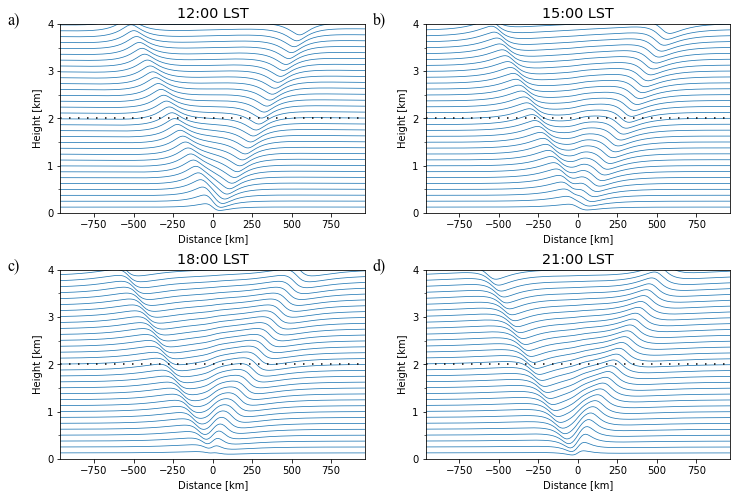

In [9]:
test = ds_pwN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)#.where(ds_cN_dim.z>=1.5e3)#.where(ds_cN_dim.z>=1.5e3)
# test = ds_pwN_dim.sum(dim='mode', keep_attrs=True).isel(forcing=1)
# test = ds_pwN_dim.isel(mode=1).isel(forcing=0)
# test = ds_pwN_dim.isel(mode=0)
var='xi'

# t=4
rt.panelCont(test, var=var, t_list=[0,2,4,6], cbar_steps=10, soltype='pwc')
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/soln_pwc_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting u.
Plotting u.
Plotting u.
Plotting u.


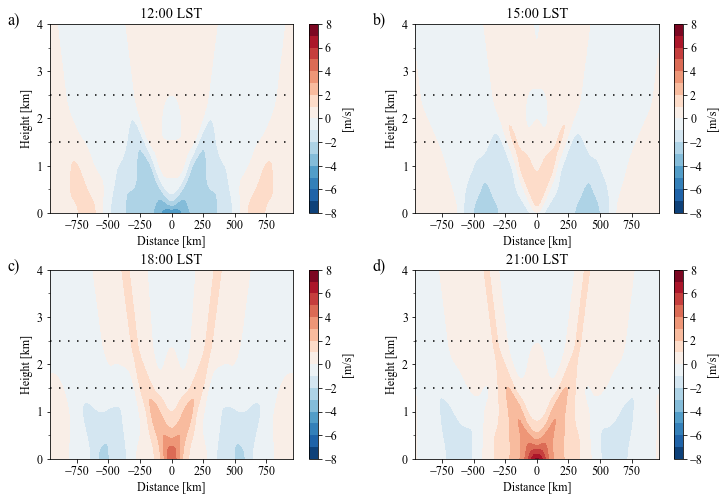

In [26]:
test = ds_cN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
# test = ds_cN_dim.sum(dim='mode', keep_attrs=True).isel(forcing=2)
# test = ds_cN_dim.isel(mode=0).isel(forcing=0)
# test = ds_pwN_dim.isel(mode=0)
var='u'
# t=4
rt.panelCont(test, var=var, t_list=[0,2,4,6], cbar_steps=10)
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/soln_cN_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting u.
Plotting u.


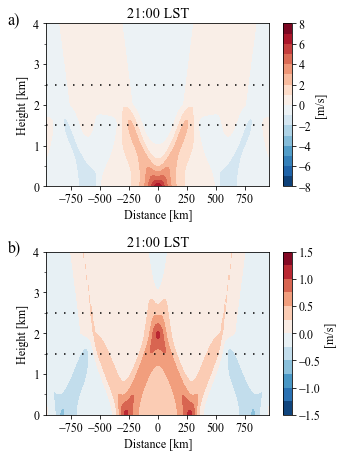

In [27]:
rt.forcingComparison(ds_pwN_dim, var='u', t=[6, 6], cbar_steps=[10, 10, 10])
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/forcing_pwc_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting u.
Plotting u.
Plotting u.


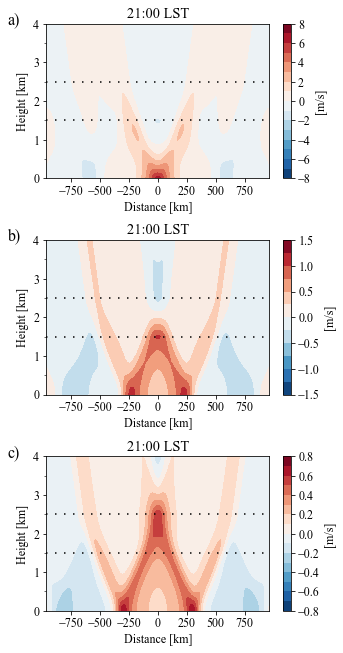

In [28]:
rt.forcingComparison(ds_cN_dim, var='u', t=[6, 6, 6], cbar_steps=[10, 10, 10])
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/forcing_cn_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting u.
Plotting u.
Plotting u.


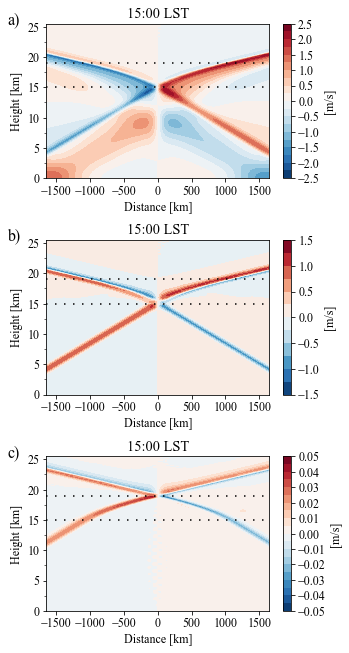

In [73]:
rt.forcingComparison(ds_cN_dim, var='u', t=[2, 2, 2], cbar_steps=[10, 10, 10])
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/forcing_cn_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting w.
Plotting velocity.
> /home/student.unimelb.edu.au/shorte1/Documents/rotunno83/python_scripts/rotunno.py(861)plotVelocity()
    859 
    860     import pdb; pdb.set_trace()
--> 861     skip_x = int(np.floor(np.size(ds.x)/16))
    862     skip_z = int(np.floor(np.size(ds.z)/16))
    863 

ipdb> c


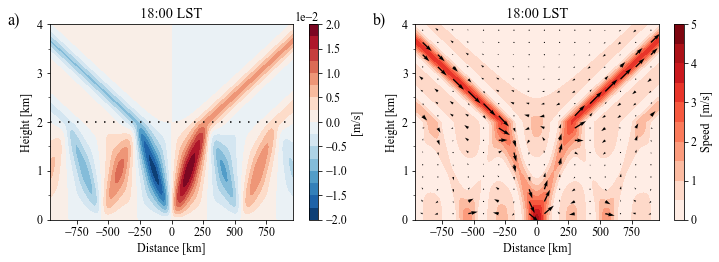

In [51]:
test = ds_pwN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
# test = ds_cN_dim.sum(dim='mode', keep_attrs=True).isel(forcing=2)
# test = ds_cN_dim.isel(mode=0).isel(forcing=0)
# test = ds_pwN_dim.isel(mode=0)
var='u'
# t=4
rt.panelDiffTypes(test, t=4)
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/diff_types_cN_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting w.
Plotting velocity.


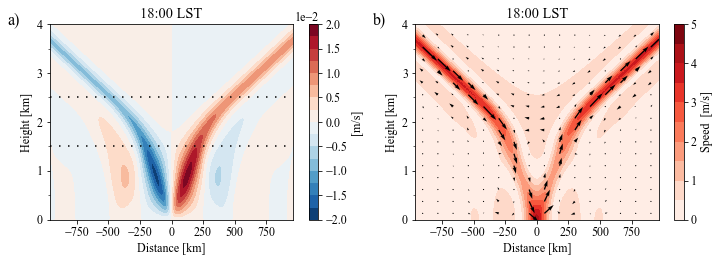

In [53]:
test = ds_cN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
# test = ds_cN_dim.sum(dim='mode', keep_attrs=True).isel(forcing=2)
# test = ds_cN_dim.isel(mode=0).isel(forcing=0)
# test = ds_pwN_dim.isel(mode=0)
var='u'
# t=4
rt.panelDiffTypes(test, t=4)
dt = rt.get_current_dt_str()
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/diff_types_cN_{}_{}_{}.png'.format(var, 0, dt), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting u.
Plotting u.


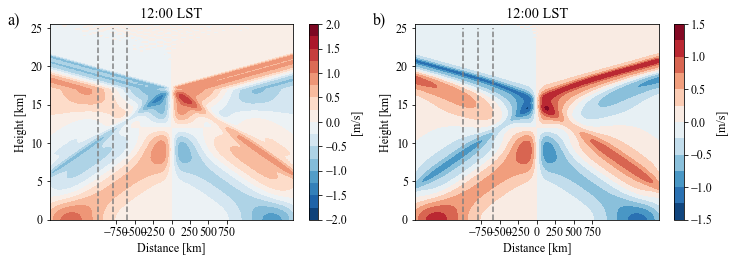

In [10]:
test1 = ds_pwN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
test2 = ds_cN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
rt.contComparison(test1, test2, t=0, var='u')

plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/YMC_comparison_{}_{}_test.png'.format('vel', 0), 
    dpi=200, bbox_inches='tight', facecolor='white')

Plotting xi.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15


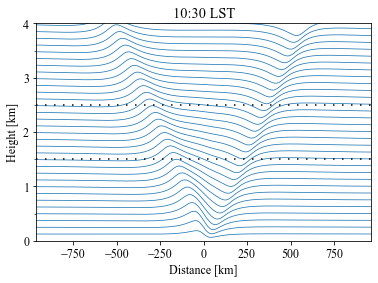

In [11]:
rt.animateDisp(ds_pwN_dim.sel(mode=[1,2]).sum(dim='mode', keep_attrs=True).sel(forcing=[1,2]).sum(dim='forcing', keep_attrs=True).squeeze(), soltype='pwn')

Plotting u.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15


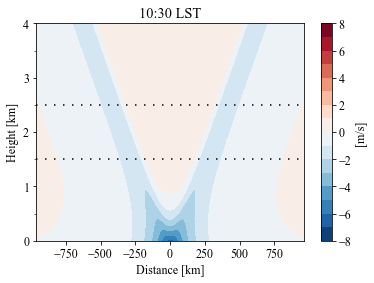

In [13]:
# rt.animateCont(ds_channel_dim.sel(mode=[1,2,3]).sum(dim='mode', keep_attrs=True).squeeze(),var='theta_q')
# rt.animateCont(ds_rotunno_dim, var='psi')

rt.animateCont(ds_pwN_dim.sel(mode=[1,2]).sum(dim='mode', keep_attrs=True).sel(forcing=[1,2]).sum(dim='forcing', keep_attrs=True).squeeze(), var='u', soltype='cn')
# rt.animateCont(ds_pwN_dim.sel(mode=[1,2]).sum(dim='mode', keep_attrs=True).isel(forcing=1).squeeze(), var='u')
# rt.animateCont(ds_qian_dim.sel(mode=[1]).sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')

# rt.animateCont(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze(),  var='theta_w')
# rt.animateCont(ds_qian_dim.sel(mode=[2]).sum(dim='mode', keep_attrs=True).squeeze(),  var='psi')
# for i in np.arange(1,7):
#     rt.animateCont(ds_qian_dim.sel(submode=i),  var='bw')
# rt.animateCont(ds_qian_dim.sel(submode=[2,3,4,5,6]).sum(dim='submode', keep_attrs=True).squeeze(),'bw')
# rt.animateCont(ds_qian_dim.sel(mode=2).squeeze(),  var='psi')

In [14]:
# rt.animateVelocity(ds_qian_dim.sum(dim='mode', keep_attrs=True).squeeze()); plt.show()
test = ds_pwN_dim.sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True)
rt.animateVelocity(test) 

Plotting velocity.
Timestep 0
Timestep 0
Timestep 1
Timestep 2
Timestep 3
Timestep 4
Timestep 5
Timestep 6
Timestep 7
Timestep 8
Timestep 9
Timestep 10
Timestep 11
Timestep 12
Timestep 13
Timestep 14
Timestep 15


In [71]:
def plot_hov(
        ds, x_list=[1000e3], var='u', signed=True, cmap='RdBu_r',
        fig=None, ax=None, c_steps=20, step_size=None, abs_max=None, transition=False):
    rt.init_fonts()
    ds_cs = ds[var].sum(dim='mode', keep_attrs=True).sum(dim='forcing', keep_attrs=True).squeeze()
    ds_cs_sum = ds_cs.sel(x=x_list[0], method='nearest')
    
    for i in range(1, len(x_list)):
        ds_cs_sum += ds_cs.sel(x=x_list[i], method='nearest')
        
    ds_cs_sum = ds_cs_sum
    ds_cs = ds_cs_sum
    
#     ds_cs = ds_cs.sel(x=-50e3, method='nearest')+ds_cs.sel(x=-6000e3, method='nearest')
    
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots(figsize=(6, 3))
        
    plt.sca(ax)

    varMin = np.min(ds_cs)
    varMax = np.max(ds_cs)

    if abs_max is None:
        abs_max = np.max([np.abs(varMin), np.abs(varMax)])

    start, stop, step = rt.nice_bounds(-abs_max, abs_max, c_steps)
    if step_size is not None:
        levels = np.arange(start, stop+step_size, step_size)
    else:
        levels = np.arange(start, stop+step, step)

    try:
        if ds_cs.z.attrs['units'] == 'm':
            z = ds.z/1000
            t = ds.t/3600
            plt.xlabel('Time [hour LST]')
            plt.ylabel('Height [km]')
        else:
            z = ds.z
            t = ds.t
            plt.xlabel('Time [' + ds.t.attrs['units'] + ']')
            plt.ylabel('Height [' + ds.z.attrs['units'] + ']')
    except:
        for var in ds_cs.keys():
            ds_cs[var].attrs['units'] = '?'
    t += 12

    contourPlot = plt.contourf(
        np.concatenate([t-24,t,t+24,[48+12]]), z, 
        np.concatenate([
            ds_cs.values.T,
            ds_cs.values.T, 
            ds_cs.values.T, 
            ds_cs.values.T[:,[0]]], axis=1),
        levels=levels, cmap=cmap)

    cbar = plt.colorbar(contourPlot)
    cbar.set_ticks(levels[::2])
    cbar.set_label('[' + ds[var].attrs['units'] + ']')
      
#     plt.title(var + ' [' + ds[var].attrs['units'] + ']')
    dt = 6
    hours = np.arange(-12,48+dt+12,dt)
    plt.xticks(hours, labels=(hours%24))
    plt.yticks(np.arange(0,30,5))
    
    ax.set_yticks(np.arange(0, 30, 5))
    ax.set_yticks(np.arange(0, 25, 2.5), minor=True)

    # import pdb; pdb.set_trace()
    if transition:
        ax.plot([hours[0], hours[-1]], [15, 15], 'k', dashes=(1, 5), zorder=4)
        ax.plot([hours[0], hours[-1]], [19, 19], 'k', dashes=(1, 5), zorder=4)
    else:
        ax.plot([hours[0], hours[-1]], [17, 17], 'k', dashes=(1, 5), zorder=4)
        
    plt.ylim([0,25])
    plt.xlim([0,48])
    fig.patch.set_facecolor('white')

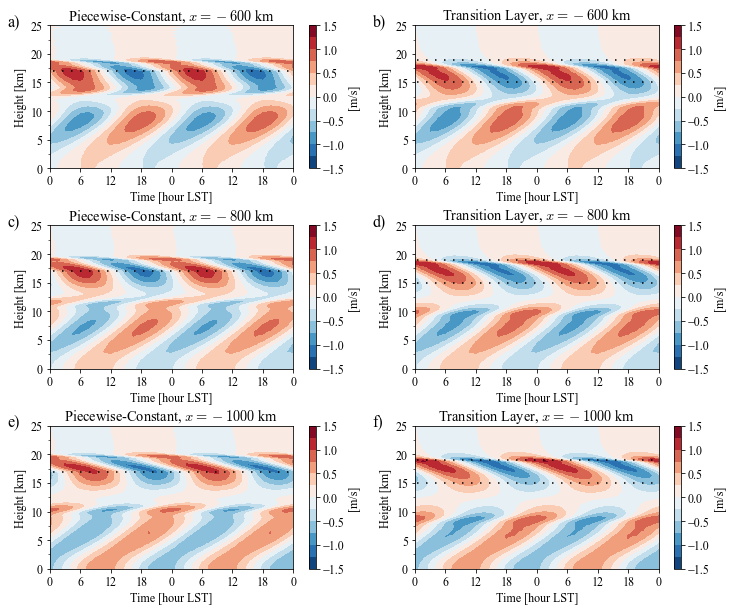

In [72]:
test = ds_cN_dim

plt.close('all')
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

plot_hov(ds_pwN_dim, x_list=[-600e3], var='u', fig=fig, ax=axes[0,0], step_size=.25)
axes[0,0].set_title('Piecewise-Constant, $x=-600$ km')
plot_hov(ds_pwN_dim, x_list=[-800e3], var='u', fig=fig, ax=axes[1,0], step_size=.25)
axes[1,0].set_title('Piecewise-Constant, $x=-800$ km')
plot_hov(ds_pwN_dim, x_list=[-1000e3], var='u', fig=fig, ax=axes[2,0], step_size=.25)
axes[2,0].set_title('Piecewise-Constant, $x=-1000$ km')

plot_hov(ds_cN_dim, x_list=[-600e3], var='u', fig=fig, ax=axes[0,1], step_size=.25, transition=True)
axes[0,1].set_title('Transition Layer, $x=-600$ km')
plot_hov(ds_cN_dim, x_list=[-800e3], var='u', fig=fig, ax=axes[1,1], step_size=.25, transition=True)
axes[1,1].set_title('Transition Layer, $x=-800$ km')
plot_hov(ds_cN_dim, x_list=[-1000e3], var='u', fig=fig, ax=axes[2,1], step_size=.25, transition=True)
axes[2,1].set_title('Transition Layer, $x=-1000$ km')

rt.make_subplot_labels(axes.flatten())
plt.subplots_adjust(hspace=.4)
plt.savefig(
    '/home/student.unimelb.edu.au/shorte1/Documents/rotunno83/figures/YMC_hovmoller_alt.png', 
    dpi=200, bbox_inches='tight', facecolor='white')